# CLUSTER-DATA-SPLIT

### Reference
This tool implements the methods described in the paper following paper.

> Hanna Wecker, Annemarie Friedrich, and Heike Adel.
*ClusterDataSplit: Evaluation Challenging Data Splits for Model Performance Evaluation*. In Proceedings of Eval4NLP 2020.

If you use this tool, please cite the above paper.


### LICENSE info
ClusterDataSplit is open-sourced under the AGPL-3.0 license. See the LICENSE file at the top level of this project for details. For a list of other open source components included in ClusterDataSplit, see the file 3rd-party-licenses.txt at the top level of this project.

# (1) Data Analysis: Multi-Class Classification Example

This notebook explores general text data characteristics such as sentence length, most frequent unigrams, and label distribution. It is intended to provide a first overview of your data and its properties.

To ensure that all packages can be loaded, run this notebook in the environment specified by the file `clusterdatasplit.yml`.

In [2]:
import sklearn
print(sklearn.__version__)
version_nr = int(sklearn.__version__.split(".")[1])
if version_nr > 23:
    print("Careful - ClusterDataSplit only works with sklearn <= version 0.23 !!")

0.23.1


In [3]:
# import packages
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display, Image
import pickle as pkl
import random
from utils import *
import os

In [4]:
# Options for Figures
sns.set(style = 'whitegrid', font = 'sans-serif', font_scale = 2)
sns.set_palette("hls", 5)
matplotlib.rcParams['figure.figsize'] = (10, 7.5)

## Inputs

Per default, this notebook expects a .tsv-file with the columns `labels` and `text_input_data`. The first line of the tsv file should contain this header. Labels are supposed to be numeric.

You can define a mapping from integers to the actual labels as strings here:

In [5]:
input_data_path = os.getcwd() + "/data/patent_classification/input_data.tsv"

In [6]:
import csv

input_data = pd.read_csv(input_data_path, delimiter = "\t")

print(input_data)

       ids labels                                    text_input_data
0        0      G  reduced start time for mems gyroscope by apply...
1        1      H  mosfet having reduced parasitic resistance and...
2        2      H  infra red camera calibration described herein ...
3        3      G  system and method for clearing depth and color...
4        4      G  method and device for embedding and detecting ...
...    ...    ...                                                ...
6453  6453      H  redirecting data flow of a secondary pdp to a ...
6454  6454      A  flexible array for use in navigated surgery a ...
6455  6455      B  nonlinear frequency dependent filtering for ve...
6456  6456      G  system and method for load testing a web-based...
6457  6457      G  machine translation method for pdf file disclo...

[6458 rows x 3 columns]


In [7]:
# In this example, we work with a 7-way multi-class classification task.
labels = sorted(np.unique(input_data["labels"]))
idx2label = {}
label2idx = {}
for i, l in enumerate(labels):
    idx2label[i] = l
    label2idx[l] = i
print(idx2label)
print(label2idx)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H'}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}


The text input data should be preprocessed, in detail, stopwords, punctuation and non-alphabetic characters should be removed and text should be lemmatized. The text input data is handed over to the notebook in its tokenized form, separated by whitespace.

In [8]:
labels = np.array([input_data['labels']])
text_data = list(input_data['text_input_data'])

In [9]:
input_data[:10] # show first 10 lines of toy dataset

,ids,labels,text_input_data
0,0,G,reduced start time for mems gyroscope by apply...
1,1,H,mosfet having reduced parasitic resistance and...
2,2,H,infra red camera calibration described herein ...
3,3,G,system and method for clearing depth and color...
4,4,G,method and device for embedding and detecting ...
5,5,D,apparatus and program stored on a computer rea...
6,6,G,partitioning of storage channels using program...
7,7,G,automatically generating valid behavior specif...
8,8,H,dynamic reconfiguration of multimedia stream p...
9,9,F,starting a compression ignition free piston in...


In [10]:
# assert that length of list matches length of ids
if not len(text_data) == len(labels[0]):
    print('Check inputs! Length of Text data and length of IDs do not match!')

In [11]:
number_ids, length_text, unique_labels, label_text_length, idx2label, label2idx = generate_overview_stats(text_data, labels)
print(label_text_length)

      label  length_text  length_text_binned
0         6          124                 164
1         7          312                 328
2         7          110                 123
3         6          198                 205
4         6          161                 164
...     ...          ...                 ...
6453      7           99                 123
6454      0           84                 123
6455      1          108                 123
6456      6           67                  82
6457      6          163                 164

[6458 rows x 3 columns]


## Text Data Analysis

Now, this notebook will give you an overview of some general statistics regarding your text data. We will explore length and label distribution and cross-statistics combining the two variables are explored.

### Dataset Size
Print the number of instances in the dataset:

In [12]:
number_ids

6458

## Text Length Statistics
### Summary Statistics

The summary statistics regarding text length contain the following items: 
- `count`: number of examples
- `mean`: mean sentence length
- `std`: standard deviation, i.e. the average difference in text length of a given example to the mean text length
- `min`: minimum text length of all examples
- `25%`: 25%-Quantil --> 25% of examples have text lengths below this value, 75% have text lengths above
- `50%`: 50%-Quantil (also called median) --> 50% of examples have a text length below this value, 50% above (i.e., if you would line up all examples sorted by text length, this is the text length of the example that would be right in the middle of the line. If the distribution regarding text length is symmetrical, median and mean are the same. If the median is not the same as the mean, this indicates the text length distribution is scewed)
- `75%`: 75%-Quantil --> interpretation see 25%
- `max`: maximum text length of all examples

In [13]:
pd.DataFrame({'Text Length': length_text}).describe().round(decimals = 2)

,Text Length
count,6458.00
mean,120.16
std,43.55
min,8.00
25%,89.00
50%,121.00
75%,149.00
max,410.00


### Histogram

The histogram delivers visual information about the text length distribution in your dataset. It plots the number of tokens in your text examples against their number of occurence. The histogram can help you identify if there are certain text lengths which occur more frequently in your data than others. For example, you could find out that there are more longer sentences in your dataset than shorter sentences by looking at the histogram.

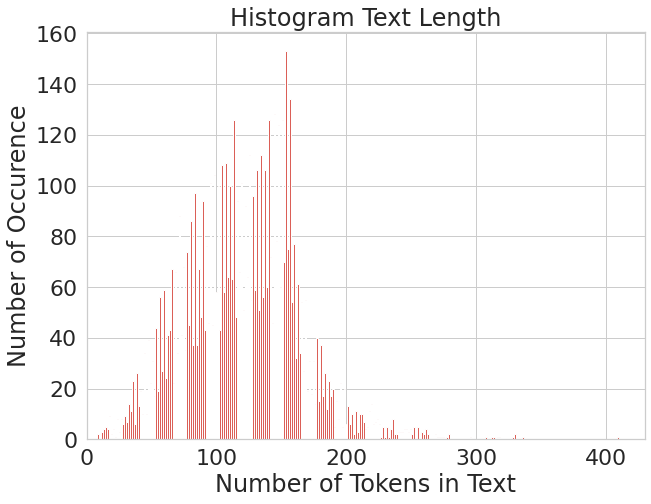

In [14]:
plot_sentence_length(length_text)

## Label Distribution

Labels are categorical and thus qualitative variables. This means that they do not have an intrinsic order (ex. label "orange" is not more or less than label "blue"). Even though labels are sometimes encoded by numbers, they should never be treated like quantitative variables (i.e., variables encoding a measurement). For example, text length is a discrete quantitative variable. It is discrete because the different numbers the variable can take on are only integers and thus countable. Quantitative Variables can be summarized by summary statistics like the one presented above. This does not make sense for qualitative variables (what should the mean of 3 blue flowers, two red ones and 1 purple one be?). Thus, the analysis of qualitative variables needs a bit more caution. Here, we explore the relative amount of examples which carry each label.

In [15]:
print_label_distribution(unique_labels, label2idx)

Label A          A: 10.78%
Label B          B: 9.94%
Label C          C: 6.97%
Label D          D: 0.65%
Label E          E: 1.87%
Label F          F: 4.26%
Label G          G: 33.23%
Label H          H: 32.30%


['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H']


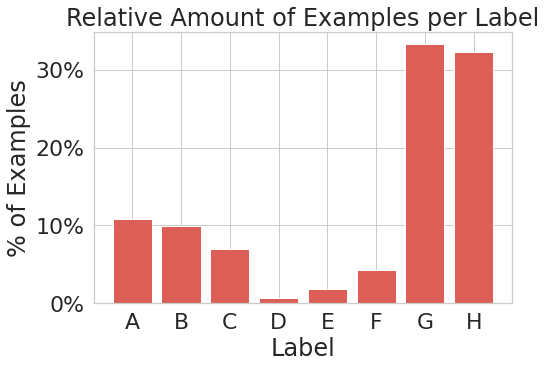

In [16]:
plot_label_distribution(unique_labels, idx2label)

### Token Frequency

Studying the token frequency in your text can give you a first hint which topics are prevalent in your data. We consider the 20 most frequent tokens in our example. If you would like to change the number of tokens displayed, change the second argument (rank) to the function "generate_tokens_and_frequencies".

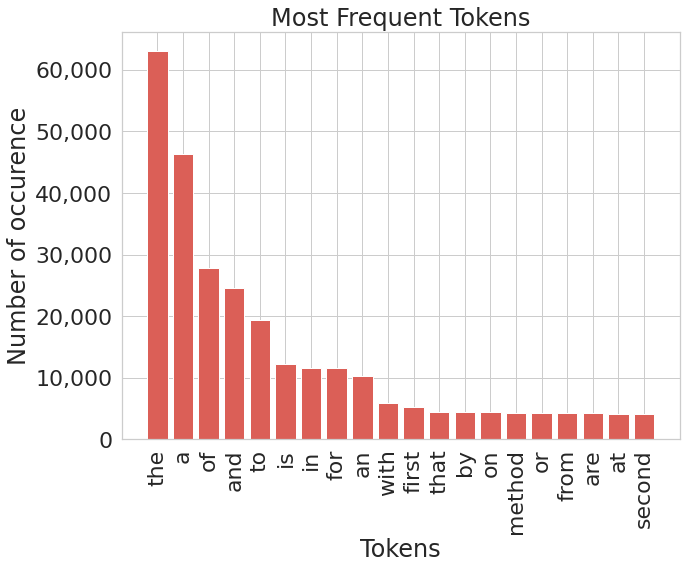

In [17]:
tokens, frequencies, full_text_string = generate_tokens_and_frequencies(text_data, rank = 20)
plot_frequent_tokens(tokens, frequencies)

### Frequent Tokens Wordcloud
As we have collected frequencies, let's create a nice image showing the relative importance of the most frequent terms in your dataset.

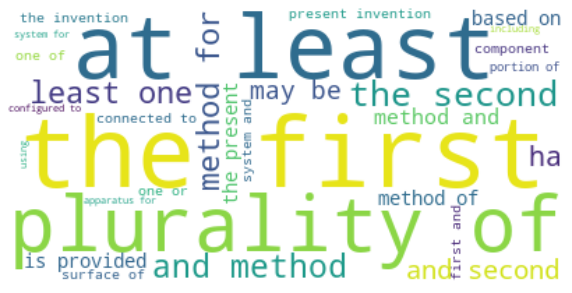

In [18]:
generate_wordcloud(full_text_string, number_of_words = 30)

### Token Frequency w.r.t. Label Statistics

Now, we study the token frequency by label. This allows us to identify if some tokens are more frequent than others with distict labels and if the examples with the different labels might focus on different topics.

*NOTE*: Dependending on your domain, it may make sense to filter out stopwords at this point using your favorite stopwords list.

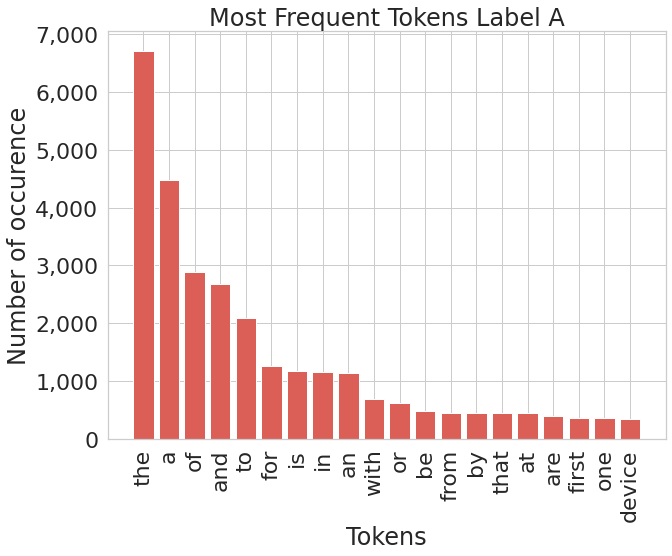

Word cloud for label A


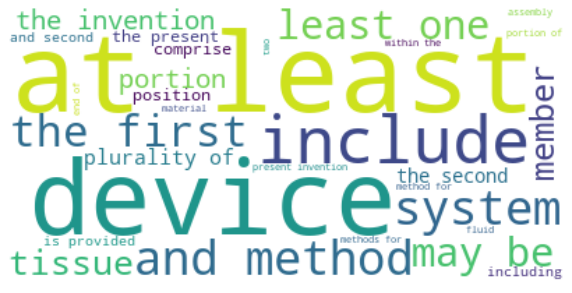

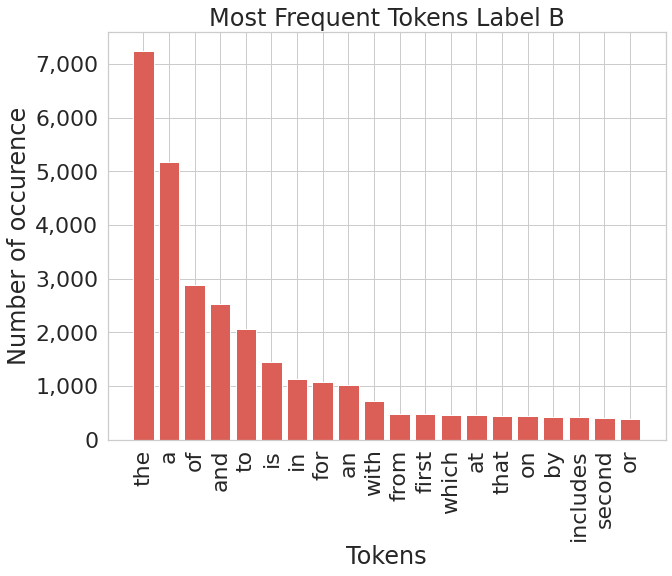

Word cloud for label B


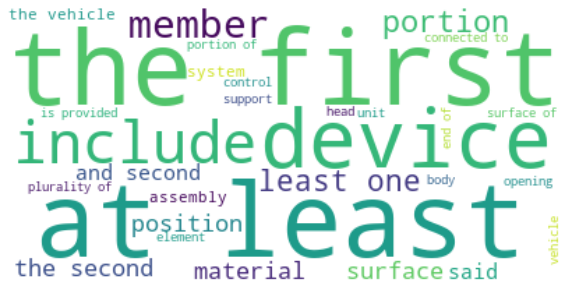

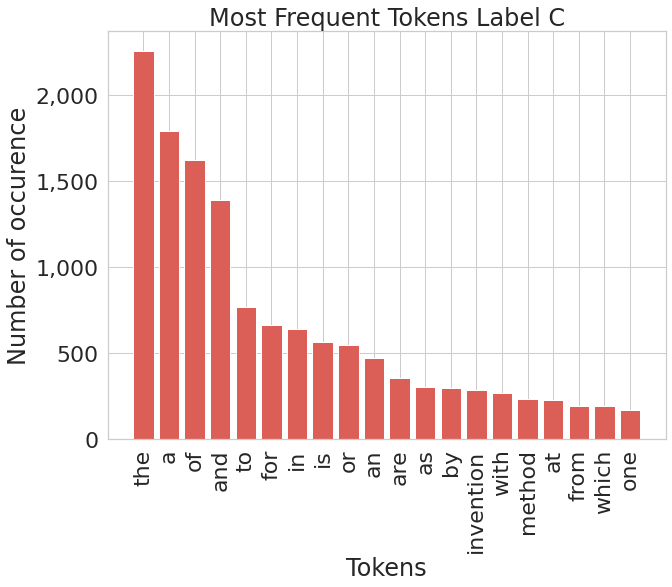

Word cloud for label C


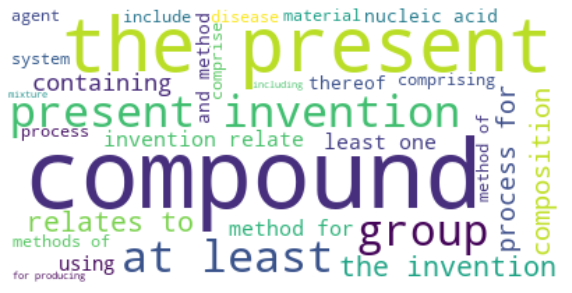

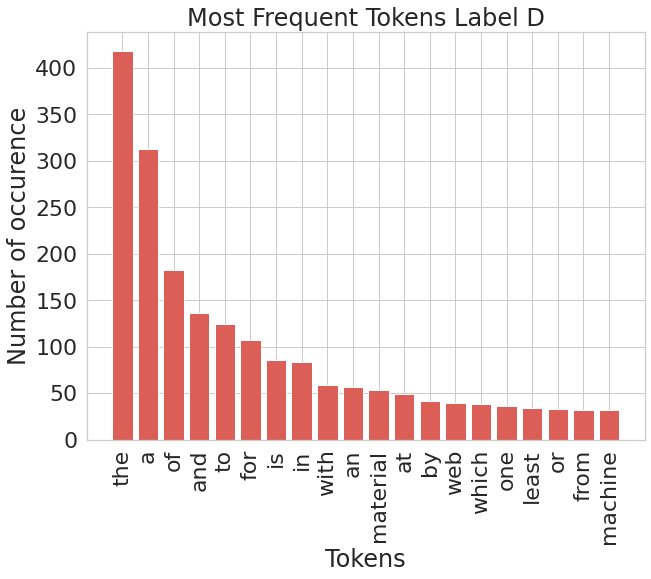

Word cloud for label D


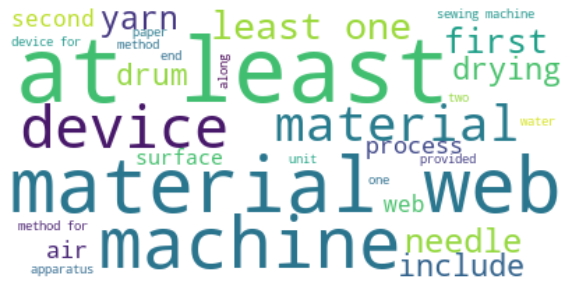

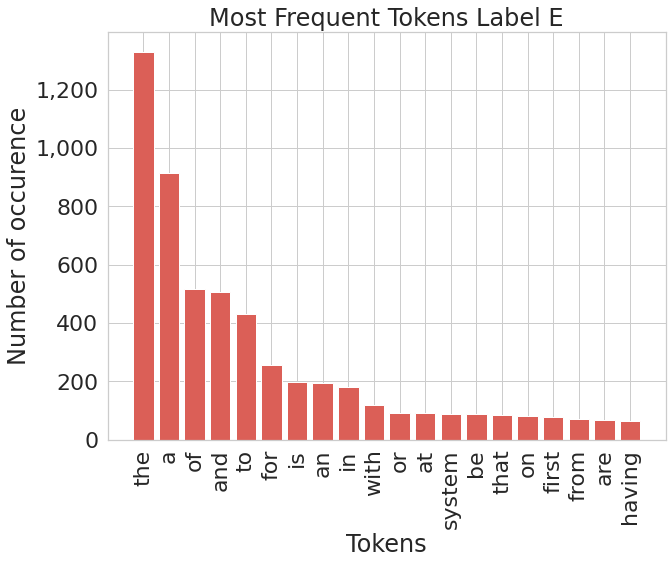

Word cloud for label E


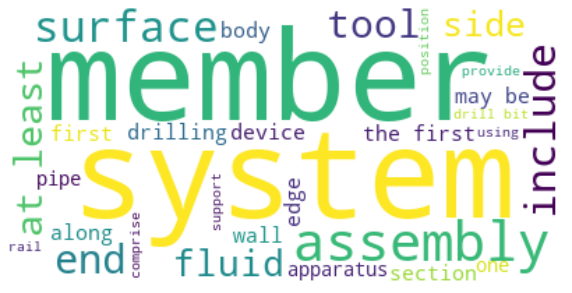

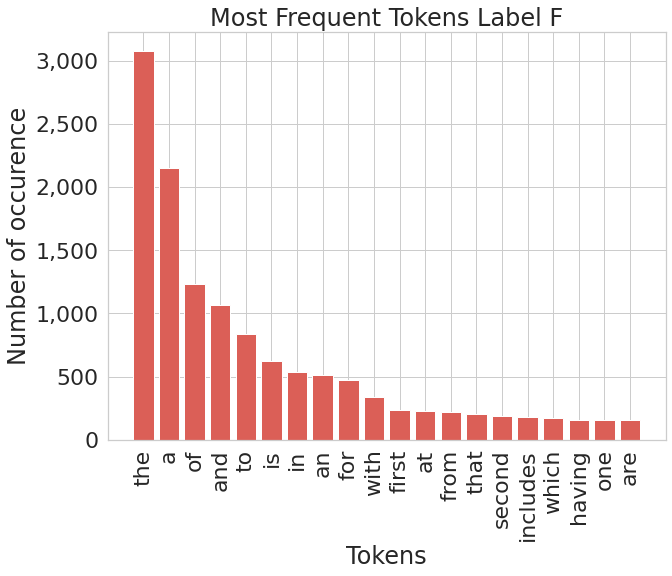

Word cloud for label F


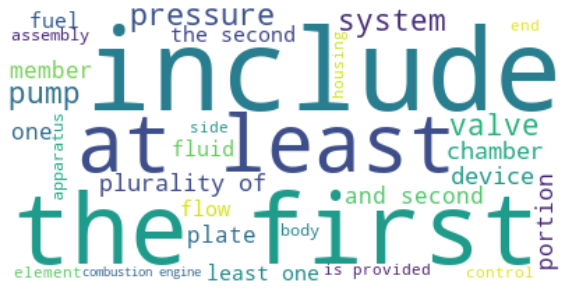

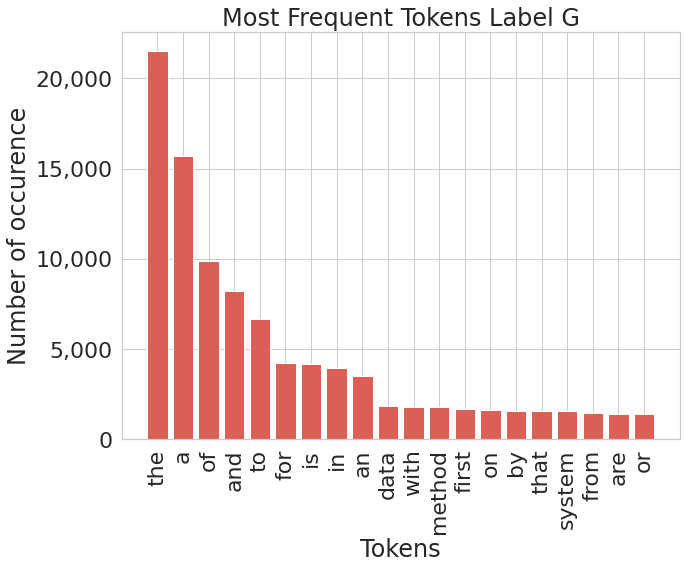

Word cloud for label G


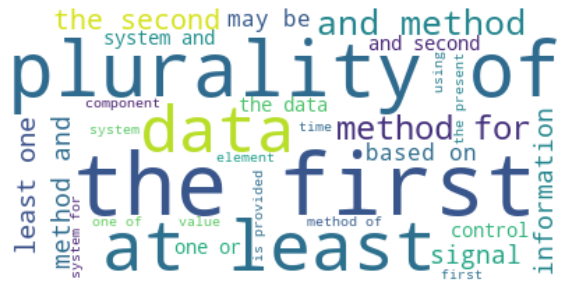

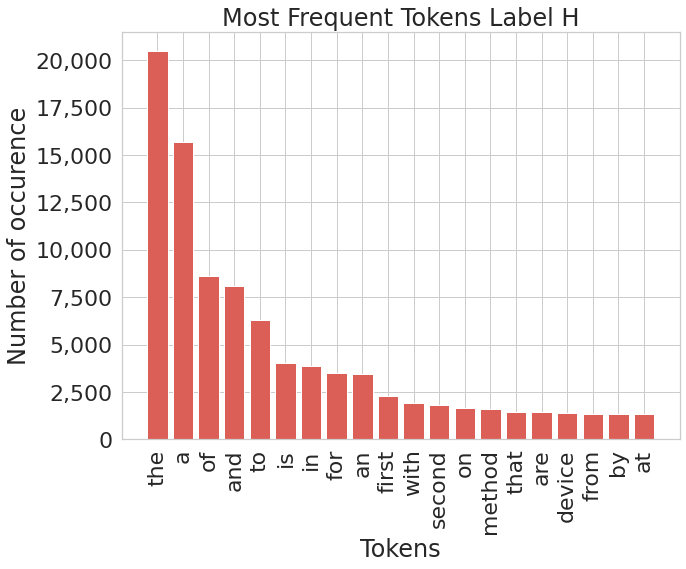

Word cloud for label H


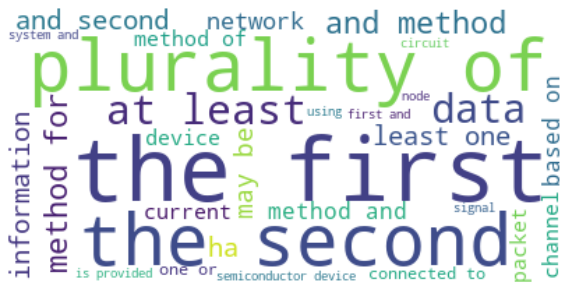

In [19]:
plot_tokens_by_label(text_data, unique_labels, idx2label, labels, rank=20)

# Text Length by Label

We next will visualize the distribution of token text lengths per label. A boxplot is suited for visualizing quantitative data in relation to a qualitative indicator. We plot the labels on the x-axis and the text lengths on the y-axis. The boxplot can be interpreted as follows. The box pictures the 25% and the 75% Quantile of the text length data (for quantile explanation, see the summary statistic above). The line through the box visualizes the median. The whiskers attached to the box visualize the minimum and maximum values lying outside the box, as long as they are not farther away from the end of the box than 1.5 times the box' length (we call the box length the inter-quartile range). Points that are farther away from the end of the boxes are called outliers and are depicted by separate points in the boxplot.

In the boxplot we can see if the distributions of text length differ structurally between the labels. For example, one would be able to see in a boxplot if the medians of the distributions per label are very far apart.

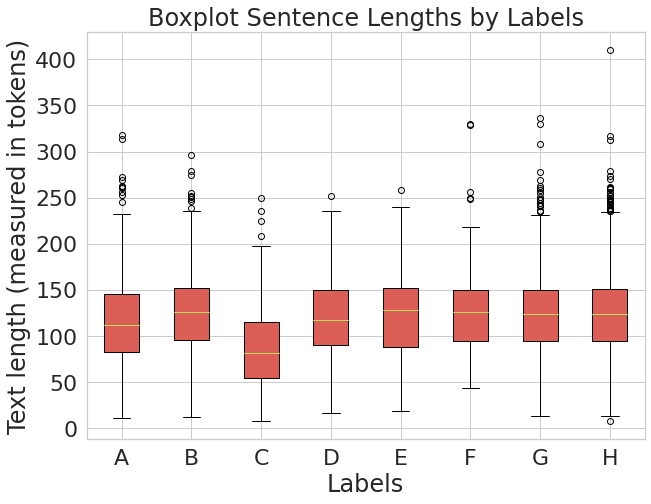

In [20]:
plot_text_length_by_labels(unique_labels, label_text_length, label2idx)

For our patents data, we can see that class C is somewhat different from the others: text are generally shorter. Classes G and H seem to have a larger number of outliers.